In [1]:
# This will be the next generation of model. The model will aim to include all relief pitchers as well as standardising the data.
# This will model will fork from model v2 and not v3. Normalised did not provide favourable results; therefore, 
# Features: Batters: Pitchers:
# Version: 1.0

In [1]:
import import_ipynb
from sklearn import svm
from pymysql import connect
from sys import path
from pathlib import Path
path.append('../../../') 
from BaseballAnalytics.bin.app_utils.queries_vTwo import Queries as Qu_VTwo
from BaseballAnalytics.bin.app_utils.consolidation.consolidating_features import Feature_Consolidater
from BaseballAnalytics.bin.app_utils.queries import Queries as Qu
from BaseballAnalytics.bin.app_utils.common_help import Log_Helper
from pickle import dump, load
from traceback import print_exc

In [2]:
# Connect to the database.
data_locs = Path(r"C:\Users\micha\Documents\GitHub\BaseballAnalytics\source_data\model_data\model_v2")      # The location of the past queries.
conn = connect(host="localhost", user="root", passwd="praquplDop#odlg73h?c", db="baseball_stats_db")
qu_vTwo = Qu_VTwo(conn)
qu = Qu(conn)

In [3]:
# Get all the game ids with the relevent information attributed to those id. Ensure to get games past May 15.
# The games are returned from earliest played to most recent.
# The 0 at the end indicates a home team victory.
game_outcomes = qu_vTwo.get_game_outcomes(day=15, month=5)            
game_outcomes = game_outcomes[200:]
game_outcomes[0:5]

[('LAN199005020', 1990, 2, 5, 6, 2, 'LAN', 'PIT', 0),
 ('MON199005020', 1990, 2, 5, 1, 8, 'MON', 'ATL', 1),
 ('NYA199005020', 1990, 2, 5, 0, 2, 'NYA', 'OAK', 1),
 ('NYN199005020', 1990, 2, 5, 5, 0, 'NYN', 'CIN', 0),
 ('PHI199005020', 1990, 2, 5, 14, 4, 'PHI', 'HOU', 0)]

In [4]:
# Get the outcomes of all the games.
game_outcomes_all = qu_vTwo.get_game_outcomes()
len(game_outcomes_all)

70101

In [5]:
# Fetch the players, pitchers, and offensive features from all the games.
pitchers_pickle = 'game_pitchers.pickle'
all_pitchers = qu_vTwo.get_pitchers_in_all_games(data_locs / pitchers_pickle)
qu_vTwo.unpack_pitchers(all_pitchers)

An Event ['langm001', '0ANA199704020']
Num Events 46
Num Games 162
Num Years 23
Num Teams 33


In [6]:
# Gather all the relief pitchers. -- POSSIBLE EXCEPTION (NOT ALL GAMES INCLUDED, GAMES MAY BE MISSING DUE TO COMPLETE GAMES)
relief_pitchers = qu_vTwo.get_relief_pitchers(all_pitchers, 25)
print("Games accounted for: {}".format(len(relief_pitchers)))
for game in relief_pitchers:
    print(game)
    print(relief_pitchers[game])
    break

The number of relievers to contian: 3
Games accounted for: 69649
ANA199704020
{'ANA': ['may-d002', 'perct001', 'jamem001'], 'BOS': ['henrb001', 'mahop001', 'sloch001']}


In [7]:
# Gather all the starting pitchers.
starting_pitchers = qu_vTwo.get_starting_pitchers(all_pitchers)
print("Games accounted for: {}".format(len(starting_pitchers)))
for game in starting_pitchers:
    print(game)
    print(starting_pitchers[game])
    break

Games accounted for: 70101
ANA199704020
{'ANA': 'langm001', 'BOS': 'gordt001'}


In [8]:
# Gather all the pitching features from the database.
pitching_feat_pickle = 'raw_pitching_features.pickle'
pitching_features = qu_vTwo.get_all_pitching_features(data_locs / pitching_feat_pickle)
for player_id in pitching_features:
    print(player_id)
    for i, game in enumerate(pitching_features[player_id]):
        print(game)
        if i > 1: break
    break

ackej001
['TEX199004090', 1.0, 2.02, 0.0]
['TOR199004120', 1.5, 1.261, 0.0]
['KCA199004150', 1.333, 2.861, 0.667]


In [9]:
# Acquire all the batters from the database.
batters_pickle = 'game_players.pickle'
all_batters = qu_vTwo.get_batters(data_locs / batters_pickle)
for game_id in all_batters:
    print(game_id)
    for i, event in enumerate(all_batters[game_id]):
        print(event)
        if i > 6: break
    break

ANA199704020
['garcn001', 0, '0ANA199704020']
['pembr001', 0, '10ANA199704020']
['haseb001', 0, '11ANA199704020']
['macks001', 0, '12ANA199704020']
['holld001', 1, '13ANA199704020']
['andeg001', 1, '14ANA199704020']
['murre001', 1, '15ANA199704020']
['leyrj001', 1, '16ANA199704020']


In [10]:
# Acquire all the batters features from the database.
offensive_feat_pickle = 'raw_offensive_features.pickle'
offensive_features = qu_vTwo.get_all_offensive_features(data_locs / offensive_feat_pickle)
for player_id in offensive_features:
    print(player_id)
    for i, game in enumerate(offensive_features[player_id]):
        print(game)
        if i > 1: break
    break

bainh001
['TEX199004090', 0.25, 1.0]
['TOR199004100', 0.25, 0.625]
['TOR199004110', 0.5, 0.625]


In [11]:
# Gather all the features from every game and separate them into X and Y.
features_pickle = 'game_features.pickle'
lh = Log_Helper()
X = []
Y = []
fc = Feature_Consolidater()
winning_pct = fc.get_win_pct(game_outcomes_all)   # Get the n game rolling average winning perct.
num_games = len(game_outcomes)
lh.print_progress_bar(0, num_games, prefix = 'Progress:', suffix = 'Complete', length = 50)    # Initial call to print 0% progress
for num, game_stats in enumerate(game_outcomes):
    try:
        X.append(fc.get_game_features(all_batters, offensive_features, all_pitchers, starting_pitchers, relief_pitchers, pitching_features, winning_pct, game_stats))
        Y.append(game_stats[8])
    except Exception as e:
        print_exc()
        print("An error as occurred at {}. The error: {}".format(game_stats[0], str(e)))
        raise ValueError("End")
    lh.print_progress_bar(num + 1, num_games, prefix = 'Progress:', suffix = 'Complete', length = 50)
with open(data_locs / features_pickle, 'wb') as f:
    dump(X, f)
#with open(data_locs / features_pickle, 'rb') as f: X = load(f)

Progress: |--------------------------------------------------| 1.5% CompleteTraceback (most recent call last):
  File "<ipython-input-11-ece352255a7b>", line 12, in <module>
    X.append(fc.get_game_features(all_batters, offensive_features, all_pitchers, starting_pitchers, relief_pitchers, pitching_features, winning_pct, game_stats))
  File "../../..\BaseballAnalytics\bin\app_utils\consolidation\consolidating_features.py", line 309, in get_game_features
    game_features += self.sub_offensive_features(offensive_features, self.get_starting_batters(all_batters, game_stats[0], 1), game_stats[0])
  File "../../..\BaseballAnalytics\bin\app_utils\consolidation\consolidating_features.py", line 163, in sub_offensive_features
    game_offensive_features += self.get_offensive_features(offensive_features, batter, game_id)
TypeError: 'NoneType' object is not iterable


ValueError: End

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Pro

In [14]:
# Split the data for modelling.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y)

In [15]:
sm = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
sm.score(X_test, y_test)

0.5483150629313845

In [16]:
rf = RandomForestClassifier(max_depth=15, random_state=0).fit(X_train, y_train)
rf.score(X_test, y_test)

0.5513601299228583

In [17]:
lr = LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.coef_, lr.intercept_)

0.5502436053593179
[[-8.66103118e-02  3.43724672e-02  3.21890038e-02  1.99398278e-01
  -7.77905777e-02 -1.98612148e-01  1.08258871e-02 -1.00157418e-01
  -1.83093017e-02 -2.52607344e-01  6.27404300e-02 -1.67346459e-01
  -1.48210412e-02 -4.09214441e-02  4.61915180e-02 -4.79945210e-01
   1.96328180e-01 -5.07409416e-02  9.81172494e-02 -9.57628180e-02
  -1.02947379e-01 -5.38142733e-03 -1.70579697e-05  2.16869942e-02
   4.71325152e-03  1.73114701e-02  1.70142876e-02 -2.27642708e-02
   1.82840197e-03  2.63574109e-02 -3.85458883e-01  9.04520607e-02
  -4.05079303e-02 -6.15995535e-02  1.78914333e-01  1.49374530e-02
  -1.24617053e-01  6.50999719e-02  1.41316038e-01 -7.82590003e-03
   1.98396415e-01  5.92629027e-02  5.15927621e-01 -1.11673759e-01
   2.25838860e-01 -4.91208242e-02 -3.26751956e-02  7.55949586e-02
   2.31140849e-01 -5.70288600e-02  3.09940138e-02  1.20881014e-01
   1.94529096e-02 -8.00964785e-03 -6.75627265e-03  2.70276979e-02
  -5.95107358e-03 -4.19305631e-02  6.72675709e-03 -8.2300

In [18]:
mlp = MLPClassifier(random_state=1, max_iter=2000).fit(X_train, y_train)
mlp.score(X_test, y_test)

0.5323792123426715

Confusion matrix, without normalization
[[3706 1506]
 [2925 1715]]
Normalized confusion matrix
[[0.71105142 0.28894858]
 [0.63038793 0.36961207]]


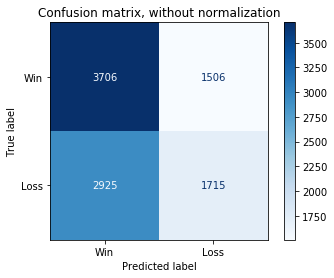

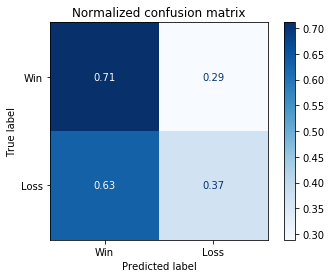

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Win', 'Loss'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [20]:
# Use cross validation to get a better idea of the models success.
from sklearn.model_selection import cross_val_score
lr_cv = LogisticRegression(max_iter=2000)
cv_scores = cross_val_score(lr_cv, X, Y, cv=5)
print(cv_scores)

[0.54267225 0.56162923 0.55561477 0.5559193  0.55276382]


In [21]:
rf_cv = RandomForestClassifier(max_depth=15, random_state=0)
cv_scores = cross_val_score(rf_cv, X, Y, cv=5)
print(cv_scores)

[0.5355158  0.5561477  0.54366197 0.54556528 0.547358  ]


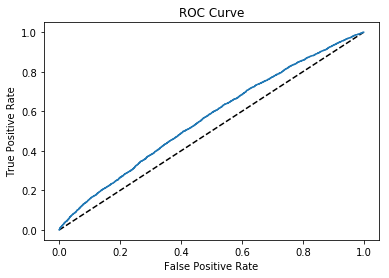

In [22]:
# Build an ROC for the Logistical Regression
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()